# Transform 2020: GemPy Workshop
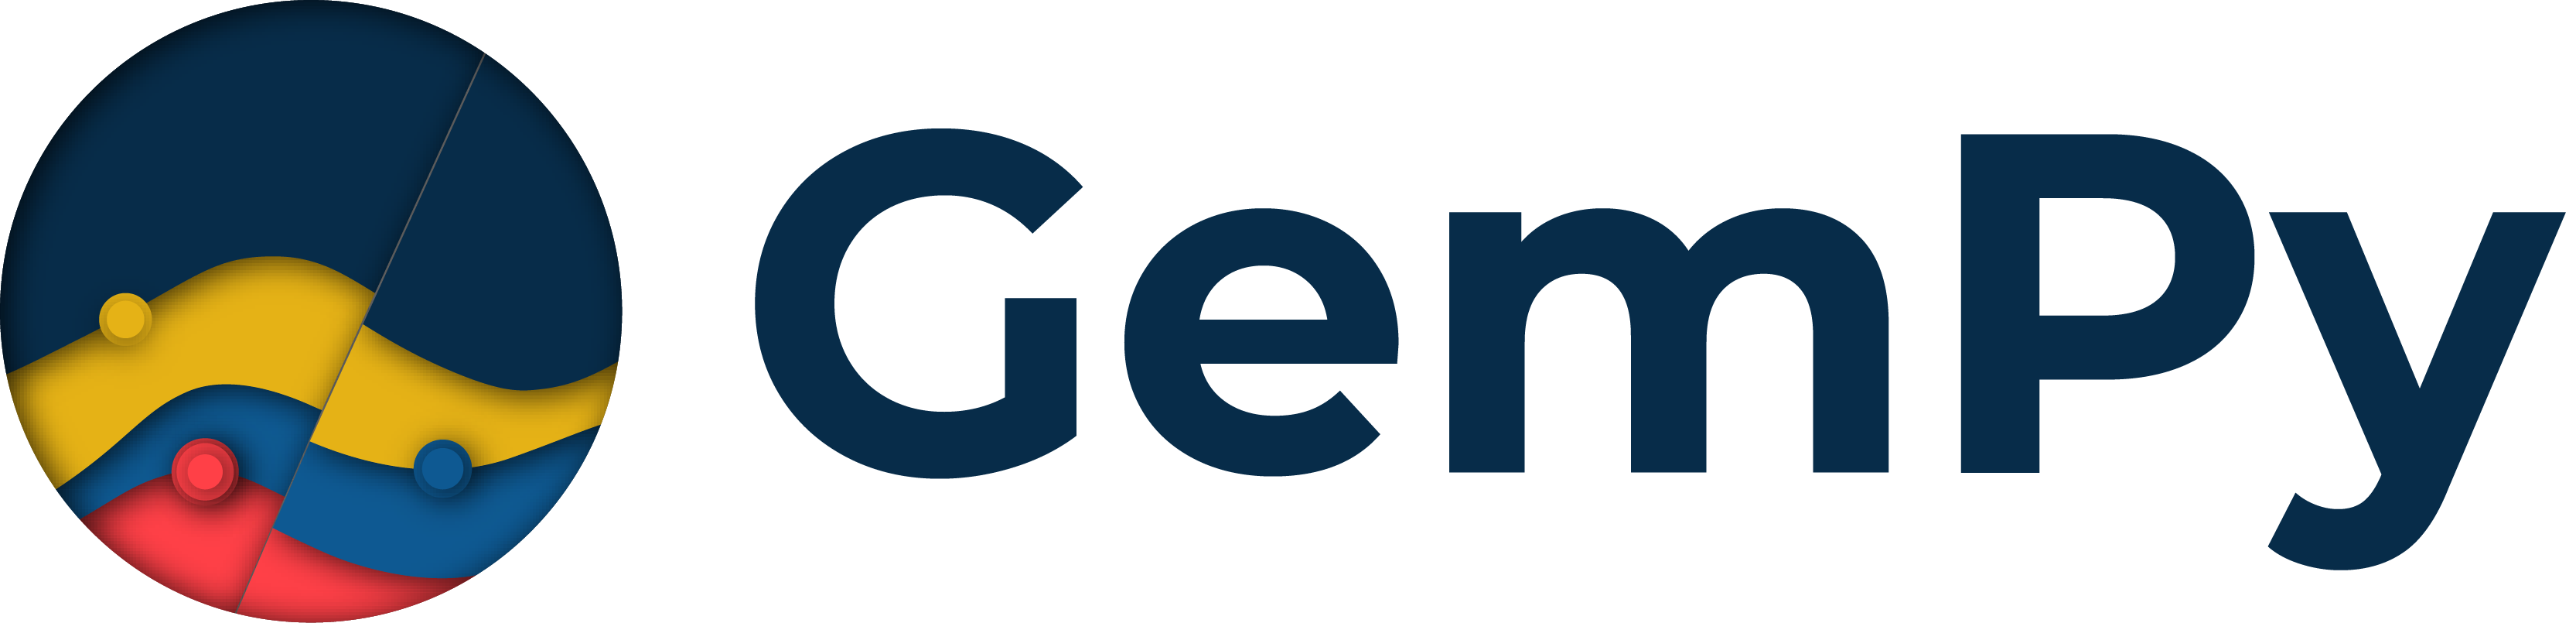

## Table of Content

- Installation - Welcome 10:00
- Your first model 10:10
- Modeling landscape by Prof. Wellmann ~10:30
- Explaning data structures 1: Overview
- Exercise: Finishing the model - 3 Extra layers ~11:00
- Explaning data structures 2: Surfaces, Surface Points, Orientations
- Unconformities and faults ~ 11:20
- **Break**
- Topography ~11:40
- Forward gravity ~11:45
- Probabilistic Modeling ~12:00


## Installation

1. Open conda prompt (Windows) or terminal (Linux/MacOS)
2. `$ conda create --clone tutorials --name t20-gempy`
0. Activate enviromet: `$ conda activate t20-gempy`
3. https://docs.gempy.org/installation.html
4. clone the repo:
    `git clone https://github.com/cgre-aachen/gempy_intro.git`
5. `$ jupyter notebook`

## Your first model

In [2]:
# Importing GemPy
import gempy as gp

# Importing aux libraries
from ipywidgets import interact
import numpy as np
import matplotlib.image as mpimg

# Embedding matplotlib figures in the notebooks
%matplotlib qt5

### Initializing the model... But first a word about Grids:

The first step to create a GemPy model is create a `gempy.Model` object that will
contain all the other data structures and necessary functionality. In addition
 for this example we will define a *regular grid* since the beginning.
This is the grid where we will interpolate the 3D geological model.

GemPy is based on a **meshless interpolator**. In practice this means that we can
interpolate any point in a 3D space. However, for convenience, we have built some
standard grids for different purposes. At the current day the standard grids are:

- **Regular grid**: default grid mainly for general visualization
- **Custom grid**: GemPy's wrapper to interpolate on a user grid
- **Topography**: Topographic data use to be of high density. Treating it as an independent
  grid allow for high resolution geological maps
- **Sections**: If we predefine the section 2D grid we can directly interpolate at those
  locations for perfect, high resolution estimations
- **Center grids**: Half sphere grids around a given point at surface. This are specially tuned
  for geophysical forward computations

For now we will use a 2.5D regular grid

In [3]:
geo_model = gp.create_model('Transform-2020')
geo_model = gp.init_data(geo_model,
                         extent= [0, 791, 0, 200, -582, 0], # of the regular grid
                         resolution=[100, 10, 100])         # of the regular grid

Active grids: ['regular']


GemPy core code is written in Python. However for efficiency and gradient based
machine learning most of heavy computations happen in optimize compile code,
 either C or CUDA for GPU.

To do so, GemPy rely on the library `Theano`. To guarantee maximum optimization
`Theano` requires to compile the code for every Python kernel. The compilation is
done by calling the following line at any point (before computing the model):

In [4]:
gp.set_interpolator(
    geo_model,
    output=['geology'], # In built outputs. More about this later on
    theano_optimizer='fast_compile') # alternatives: 'fast_run' or
                                     # check http://deeplearning.net/software/theano/tutorial/modes.html                        

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range             1002.2
$C_o$            23914.4
drift equations      [3]


### Creating figure:

GemPy uses `matplotlib` and `pyvista` for 2d and 3d visualization of the model respectively. One of the
design decisions of GemPy is to allow real time construction of the model. What this means is that you can start
adding input data and see in real time how the 3D surfaces evolve. Lets initialize the visualization windows.

The first one is the 2d figure. Just place the window where you can see it (maybe move the jupyter notebook to half
screen and use the other half for the renderers).

In [5]:
p2d = gp.plot_2d(geo_model, section_names=None,
                 direction=None, cell_number=None)

#### Add model section

In the 2d renderer we can add several cross section of the model. In this case, for simplicity sake we are just
adding one perpendicular to y.

In [6]:
# In this case perpendicular to the y axes
ax = p2d.add_section(cell_number=1, direction='y')

#### Loading cross-section image:

Remember that `gempy` is simply using `matplotlib` and therefore the ax object
 created above is a standard `matplotlib` axes.

Lets load an image with the information of couple of boreholes

In [7]:
# Reading image
img = mpimg.imread('wells.png')
# Plotting it inplace
ax.imshow(img, origin='upper', alpha=.8, extent = (0, 791, -582,0))

We can do the same in 3D through `pyvista` and vtk rendering.

Click the qt5 button Back (+Y) to have the same view as in the 2D viewer:

In [8]:
p3d = gp.plot_3d(geo_model, plotter_type='background', notebook=False)

## Building the model

Now that we have the model initialize and the 2D and 3D render in place we can
 start the construction of the geological model. 

### Surfaces

GemPy is a surface based interpolator. This means that all the input data we add has to be refereed to a surface. The
 surfaces always mark the **bottom** of a unit. 
 
 By default GemPy surfaces are empty:

In [9]:
geo_model.surfaces

Empty DataFrame
Columns: [surface, series, order_surfaces, color, id]
Index: []

If we do not care about the names and we just want to interpolate a surface we can use.
It is important to notice that **the bottom
most layer will be considered always basement and therefore not interpolated**. Still
we can add values or change the color of that "surface" (for lack of a better name) to
populate the lower most volume.


In [10]:
# Default surfaces:
geo_model.set_default_surfaces()

surface          series  order_surfaces    color  id
0  surface1  Default series               1  #015482   1
1  surface2  Default series               2  #9f0052   2

We will see more about data structures below.

Now we can start adding data. GemPy input data consist on surface points and
orientations (perpendicular to the layers). The 2D plot gives you the X and Z coordinates when hovering the mouse
 over. We can add a surface point as follows:


In [11]:
# Add a point. If idx is None, next available index will be used. Here we pass it
# explicitly for consistency
geo_model.add_surface_points(X=223, Y=0.01, Z=-94, surface='surface1', idx=0)

# Plot in 2D
p2d.plot_data(ax, cell_number=11)

# Plot in 3D
p3d.plot_data()

Now we can add the other two points of the layer:

In [12]:
# Add points
geo_model.add_surface_points(X=458, Y=0, Z=-107, surface='surface1', idx=1)
geo_model.add_surface_points(X=612, Y=0, Z=-14, surface='surface1', idx=2)

# Plotting
p2d.plot_data(ax, cell_number=11)
p3d.plot_surface_points()

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000002329F622EE8

In [15]:
geo_model.surface_points

X     Y      Z    smooth   surface
0  223.0  0.01  -94.0  0.000001  surface1
1  458.0  0.00 -107.0  0.000001  surface1
2  612.0  0.00  -14.0  0.000001  surface1

The **minimum amount of input data** to interpolate anything in `gempy` is:

a) 2 surface points per surface

b) One orientation per series.

Lets add an orientation anywhere in space:

In [16]:
# Adding orientation
geo_model.add_orientations(X=350, Y=0, Z=-300, surface='surface1',
                           pole_vector= (0,0,1))
p2d.plot_data(ax, cell_number=5)
p3d.plot_data()

Now we have enough data to finally **interpolate**!

In [17]:
gp.compute_model(geo_model)


Lithology ids 
  [2. 2. 2. ... 2. 2. 2.] 

That is, we have interpolated the 3D surface. We can visualize with:

In [19]:
# In 2D
p2d.plot_contacts(ax, cell_number=5)

# In 3D
p3d.plot_surfaces()
p3d.plot_structured_grid()

[StructuredGrid (0x232b4bc3828)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	2,

In [20]:
geo_model.surfaces

surface          series  order_surfaces    color  id
0  surface1  Default series               1  #015482   1
1  surface2  Default series               2  #9f0052   2

Congratulations! You have learnt how to create a surface. From here on, we will
learn how to combine multiple surfaces to little by little construct a full realize
3D structural model.

-----------
## Intermission: GemPy data classes

GemPy depends on multiple data objects to store all the data structures necessary
to construct an structural model. To keep all the necessary objects in sync the
class `gempy.ImplicitCoKriging` (which `geo_model` is instance of) will provide the
necessary methods to update these data structures coherently.

At current state (gempy 2.2), the data classes are:

- `gempy.SurfacePoints`
- `gempy.Orientations`
- `gempy.Surfaces`
- `gempy.Stack` (combination of `gempy.Series` and `gempy.Faults`)
- `gempy.Grid`
- `gempy.AdditionalData`
- `gempy.Solutions`

Today we will look into details only some of these classes but what is important
to notice is that you can access these objects as follows:

In [24]:
# The default surfaces once again
geo_model.surfaces

surface          series  order_surfaces    color  id
0  surface1  Default series               1  #015482   1
1  surface2  Default series               2  #9f0052   2

In [29]:
# Also the surface points

X    Y      Z       X_r       Y_r       Z_r  G_x  G_y  G_z  dip  \
0  350.0  0.0 -300.0  0.413339  0.500094  0.316295  0.0  0.0  1.0  0.0   

   azimuth  polarity   surface          series  id  order_series  smooth  
0      0.0       1.0  surface1  Default series   1             1    0.01

In [ ]:
# Orientations

In [32]:
# To find the location of the surface we just plot
geo_model.solutions.vertices

[array([[  3.955     ,  10.        , -64.28490875],
        [  3.955     ,  30.        , -64.3000058 ],
        [ 11.865     ,  10.        , -64.6319632 ],
        ...,
        [624.85240288, 110.        ,  -2.91      ],
        [623.23234711, 130.        ,  -2.91      ],
        [621.12407188, 150.        ,  -2.91      ]])]

In [33]:
# The grid values:
geo_model.grid, len(geo_model.grid.values)

(Grid Object. Values: 
 array([[   3.955,   10.   , -579.09 ],
        [   3.955,   10.   , -573.27 ],
        [   3.955,   10.   , -567.45 ],
        ...,
        [ 787.045,  190.   ,  -14.55 ],
        [ 787.045,  190.   ,   -8.73 ],
        [ 787.045,  190.   ,   -2.91 ]]),
 100000)

In [34]:
# And its correspondent ids:
geo_model.solutions.lith_block, len(geo_model.solutions.lith_block)

(array([2., 2., 2., ..., 2., 2., 2.]), 100000)

------

## Adding more layers

<div class="alert alert-block alert-warning">
<b>Exercise:</b> So far we only need 2 units defined. The cross-section image that
 we load have 4 however. Lets add two layers more:
</div>

### Layer 2

First we need to add some more layers.

In [35]:
# We can add already two extra surfaces
geo_model.add_surfaces(['surface3', 'basement'])

surface          series  order_surfaces    color  id
0  surface1  Default series               1  #015482   1
1  surface2  Default series               2  #9f0052   2
2  surface3  Default series               3  #ffbe00   3
3  basement  Default series               4  #728f02   4

In [36]:
# Your code here:
geo_model.add_surface_points(X=225, Y=0, Z=-269, surface='surface2', idx=3)
geo_model.add_surface_points(X=459, Y=0, Z=-279, surface='surface2', idx=4)

#--------------------
# Plot data
p2d.plot_data(ax)
p3d.plot_data()

In [37]:
# Compute model
gp.compute_model(geo_model)

# Plot 2D
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

# Plot 3D
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {1: 'surface1', 2:'surface2', 3:'surface3'})


[StructuredGrid (0x232b4bc3828)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	2,

### Layer 3

In [38]:
# Your code here:
# Add points
geo_model.add_surface_points(X=225, Y=0, Z=-439, surface='surface3')
geo_model.add_surface_points(X=464, Y=0, Z=-456, surface='surface3')
geo_model.add_surface_points(X=619, Y=0, Z=-433, surface='surface3')

# Compute model
gp.compute_model(geo_model)

# Plotting
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {1: 'surface1', 2:'surface2', 3:'surface3', 4:'basement'})
p3d.plot_data()
# ------------------

In [44]:
# Showing scalar field
gp.plot_2d(geo_model, show_scalar=True)

In [ ]:
# gp.save_model_to_pickle(geo_model, 'checkpoint1')

-------------------
## Intermission: GemPy data structures: Surfaces Points, Orientations and surfaces

On GemPy each surface is not independent of each other. Some surfaces will be
subparallel to each other while other surfaces will define a fault plane where
an offset may occur.

In order to account for all possible combinations, we use **categories** (in many
instances literal `pandas.CategoricalDtype`) and **ordered** `pandas.Dataframes`.
Let's take a look at `gempy.SurfacePoints`:

In [45]:
geo_model.surface_points

X     Y      Z    smooth   surface
0  223.0  0.01  -94.0  0.000001  surface1
1  458.0  0.00 -107.0  0.000001  surface1
2  612.0  0.00  -14.0  0.000001  surface1
3  225.0  0.00 -269.0  0.000001  surface2
4  459.0  0.00 -279.0  0.000001  surface2
5  225.0  0.00 -439.0  0.000001  surface3
6  464.0  0.00 -456.0  0.000001  surface3
7  619.0  0.00 -433.0  0.000001  surface3

As we can see each point belong to a given surface. If now we look at the
`gempy.Surface` object:

In [46]:
geo_model.surfaces

surface          series  order_surfaces    color  id
0  surface1  Default series               1  #015482   1
1  surface2  Default series               2  #9f0052   2
2  surface3  Default series               3  #ffbe00   3
3  basement  Default series               4  #728f02   4

Here we can find the properties related to a each surface. Special attention
to the column series. At the moment all surfaces belong to the same series
and therefore they will be interpolated together in that characteristic subparallel
pattern.

Now we will see how by playing with the series we can define unconformities and
faults

--------------

<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

In [47]:
geo_model = gp.load_model_pickle('checkpoint1.pickle')

# Default plotting setting
p2d = gp.plot_2d(geo_model)
ax = p2d.axes[0]
# Reading image
img = mpimg.imread('wells.png')
# Plotting it inplace
ax.imshow(img, origin='upper', alpha=.8, extent = (0, 791, -582,0))
p3d = gp.plot_3d(geo_model, plotter_type='background')

---------
## Unconformities and Faults:

So far the model is simply a depositional unit. GemPy allows for unconformities
and faults to build complex models. This input is given by categorical data. In general:

**Geometric Data** (surface points/ orientations) <belong to< **surface** <belong to< **series**

And series can be a fault---i.e. offset the rest of surface--- or not. We are going to show how to add a fault as an example.

First we need to add a series:

### Erosion

In [48]:
geo_model.add_features('Discontinuity')

order_series BottomRelation  isActive  isFault  isFinite
Default series             1        Erosion      True    False     False
Discontinuity              2        Erosion     False    False     False

Now there are two different series/features but not a surface that belong to it.
Therefore, we also need to add a new surface:

In [49]:
geo_model.add_surfaces('discontinuity1')

surface          series  order_surfaces    color  id
0        surface1  Default series               1  #015482   1
1        surface2  Default series               2  #9f0052   2
2        surface3  Default series               3  #ffbe00   3
3        basement  Default series               4  #728f02   4
4  discontinuity1   Discontinuity               1  #443988   5

Linking series/feature with surface:

In [50]:
gp.map_stack_to_surfaces(geo_model, {'Discontinuity':'discontinuity1'})


surface          series  order_surfaces    color  id
0        surface1  Default series               1  #015482   1
1        surface2  Default series               2  #9f0052   2
2        surface3  Default series               3  #ffbe00   3
3        basement  Default series               4  #728f02   4
4  discontinuity1   Discontinuity               1  #443988   5

Notice that by default it is defining an erosion.

In [51]:
geo_model.reorder_features(['Discontinuity', 'Default series'])

order_series BottomRelation  isActive  isFault  isFinite
Discontinuity              1        Erosion     False    False     False
Default series             2        Erosion      True    False     False

In [52]:
geo_model.surfaces

surface          series  order_surfaces    color  id
4  discontinuity1   Discontinuity               1  #443988   1
0        surface1  Default series               1  #015482   2
1        surface2  Default series               2  #9f0052   3
2        surface3  Default series               3  #ffbe00   4
3        basement  Default series               4  #728f02   5

Now we can just add input data as before (remember the minimum amount of input data to compute a model):

In [53]:
# Add input data of the fault
geo_model.add_surface_points(X=550, Y=0, Z=-30, surface='discontinuity1')
geo_model.add_surface_points(X=650, Y=0, Z=-200, surface='discontinuity1')
geo_model.add_orientations(X=600, Y=0, Z= -100, surface='discontinuity1',
                           pole_vector=(.3,0,.3))
# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p3d.remove_actor(p3d.regular_grid_actor) # Removing the previous regular grid because
                                         # we are changing the colors and gets messy
p3d.plot_data()

If we compute now the model the purple plane will erode the previous surfaces
and layers:

In [54]:
# Compute
gp.compute_model(geo_model)

# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_data()
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {2: 'surface1', 3:'surface2',
                                                    4:'surface3', 5:'basement'})

[StructuredGrid (0x232b55adb28)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	3,

### Onlap

If the relation should be onlap we just need to change the type of series/feature
of discontinuity

In [55]:
geo_model.set_bottom_relation('Discontinuity', 'Onlap')


# %%

# Compute
gp.compute_model(geo_model)

# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_data()
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {2: 'surface1', 3:'surface2',
                                                    4:'surface3', 5:'basement'})

[StructuredGrid (0x232b55adb28)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	3,

### Fault

Then define that is a fault. It is possible to do this either by the `set_bottom_relation`
method or `set_is_fault`.

In [56]:
geo_model.set_is_fault('Discontinuity')

Fault colors changed. If you do not like this behavior, set change_color to False.


order_series BottomRelation  isActive  isFault  isFinite
Discontinuity              1          Fault      True     True     False
Default series             2        Erosion      True    False     False

And now is computing as before:

In [57]:
# Compute
gp.compute_model(geo_model)

# Plot
p2d.remove(ax)
p2d.plot_data(ax, cell_number=5)
p2d.plot_lith(ax, cell_number=5)
p2d.plot_contacts(ax, cell_number=5)

p3d.plot_data()
p3d.plot_surfaces()
p3d.plot_structured_grid(opacity=.2, annotations = {2: 'surface1', 3:'surface2',
                                                    4:'surface3', 5:'basement'})

[StructuredGrid (0x232b55adb28)
   N Cells:	88209
   N Points:	100000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -2.910e+00
   Dimensions:	100, 10, 100
   N Arrays:	3,

By using multiple series/features instead of having folding layers we can have sharp
 interfaces. This opens

## Additional features:

Over the years we have built a bunch of assets integrate with `gempy`.
 Here we will show some of them:

### Topography

GemPy has a built-in capabilities to read and manipulate topographic data (through gdal).
 To show an example we can just create a random topography:

In [58]:
## Adding random topography
geo_model.set_topography(source='random', fd=1.9, d_z=np.array([-150, 0]),
                         resolution=np.array([200,200]))

Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   3.955     ,   10.        , -579.09      ],
       [   3.955     ,   10.        , -573.27      ],
       [   3.955     ,   10.        , -567.45      ],
       ...,
       [ 791.        ,  197.98994975, -143.98133832],
       [ 791.        ,  198.99497487, -143.62358681],
       [ 791.        ,  200.        , -144.3110738 ]])

The topography can we visualize in both renderers:

In [59]:
p2d.plot_topography(ax, cell_number=5)
p3d.plot_topography(scalars='topography')

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)00000232B79FC1C8

But also allows us to compute the geological map of an area:

In [60]:
gp.compute_model(geo_model)
p3d.plot_surfaces()
p3d.plot_topography()

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)00000232BD0376A8

In [61]:
p3d.plot_structured_grid()

[UnstructuredGrid (0x232b79fc648)
   N Cells:	75743
   N Points:	87000
   X Bounds:	3.955e+00, 7.870e+02
   Y Bounds:	1.000e+01, 1.900e+02
   Z Bounds:	-5.791e+02, -1.455e+01
   N Arrays:	3,

In [ ]:
# gp.save_model_to_pickle(geo_model, 'checkpoint2')

--------------

<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

In [62]:
geo_model = gp.load_model_pickle('checkpoint2.pickle')

# Default plotting setting
p2d = gp.plot_2d(geo_model)
ax = p2d.axes[0]
# Reading image
img = mpimg.imread('wells.png')
# Plotting it inplace
ax.imshow(img, origin='upper', alpha=.8, extent = (0, 791, -582,0))
p3d = gp.plot_3d(geo_model, plotter_type='background', show_topography=True)


### Forward gravity

GemPy also allows for inversions. We can see a small demo how this works.

The first thing to do is to assign densities to each of the units:

In [63]:
geo_model.add_surface_values([0, 2.6, 2.4, 3.2, 3.6], ['density'])

surface          series  order_surfaces    color  id  density
4  discontinuity1   Discontinuity               1  #527682   1      0.0
0        surface1  Default series               1  #015482   2      2.6
1        surface2  Default series               2  #9f0052   3      2.4
2        surface3  Default series               3  #ffbe00   4      3.2
3        basement  Default series               4  #728f02   5      3.6

Also we can create a centered grid around a device for precision:

In [64]:
geo_model.set_centered_grid(centers= [[400, 0, 0]], 
                            resolution = [10, 10, 100],
                            radius=800)

Active grids: ['regular' 'topography' 'centered']


Grid Object. Values: 
array([[    3.955     ,    10.        ,  -579.09      ],
       [    3.955     ,    10.        ,  -573.27      ],
       [    3.955     ,    10.        ,  -567.45      ],
       ...,
       [ 1200.        ,   800.        ,  -922.71624587],
       [ 1200.        ,   800.        ,  -964.3665184 ],
       [ 1200.        ,   800.        , -1008.        ]])

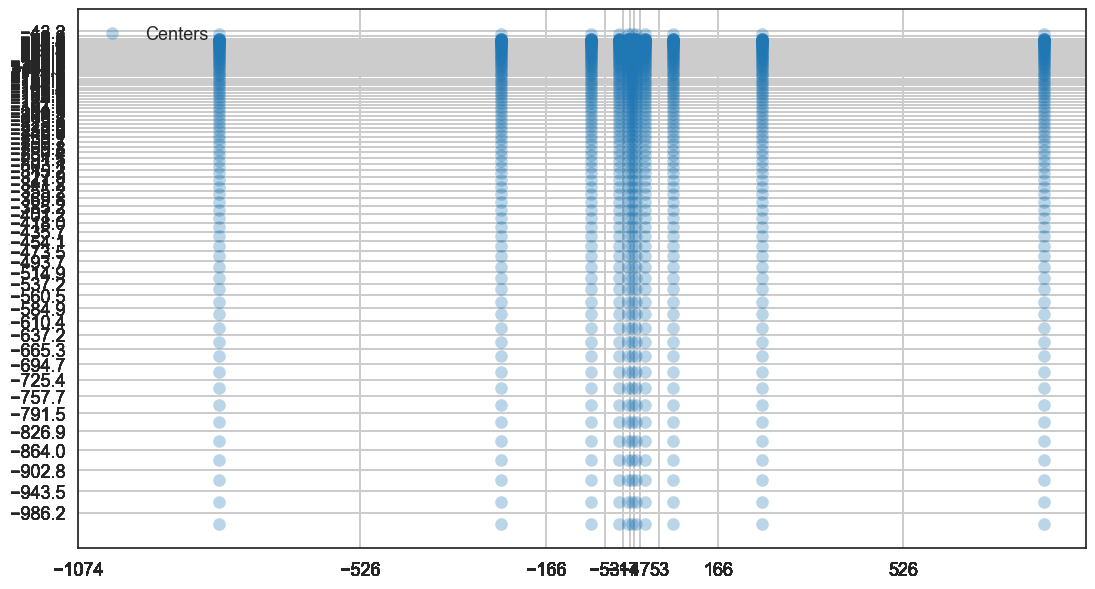

In [67]:
from aux_func import plot_centered_grid
plot_centered_grid(geo_model.grid.centered_grid)

We need to modify the graph to add the branch of algebra necessary to compute
 gravity from prisms. This also means that we need to recompile the `theano`
 function:

In [68]:
gp.set_interpolator(geo_model, output=['gravity'], theano_optimizer='fast_run')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                   values
range             1002.2
$C_o$            23914.4
drift equations   [3, 3]


But now additionally to the interpolation we also compute the forward gravity of
 the model (at the point XYZ = 400, 0, 0)

In [69]:
gp.compute_model(geo_model)
geo_model.solutions.fw_gravity

array([-80.36323181])

We can visualize it it better in the following figure. The aim of an inversion is to find the set of parameters that 
fit a measured point the better. In this example the red x symbolize the measured gravity while  the blue dots are 
the current gravity (and previous) fw gravity values.  The widget moves up and down the surface 3

In [71]:
from aux_func import plot_grav_inter
grav_invert = plot_grav_inter(geo_model)

In [72]:
interact(grav_invert, dz=(-200, 200, 10))

interactive(children=(IntSlider(value=0, description='dz', max=200, min=-200, step=10), Output()), _dom_classe…

<function aux_func.plot_grav_inter.<locals>.gravity_invert(dz)>

In [ ]:
# gp.save_model_to_pickle(geo_model, 'checkpoint3')

-----------

<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

___________

## Probabilistic Modeling

When dealing with geological data, uncertainty is always present. Device precision
and error, interpretations or extrapolations, the sources of uncertainty are
many and very heterogeneous. Probabilistic modeling enable to capture some
of this epistemic uncertainty - i.e. lack of knowledge - into **aleatoric** uncertainty
that we can represent by probability distributions.

In this tutorial be will introduce some basic concepts and building blocks and
how all can be coupled with `gempy`.

In [84]:
import gempy as gp
import numpy as np
%matplotlib inline
geo_model = gp.load_model_pickle('checkpoint3.pickle')
p3d = gp.plot_3d(geo_model, plotter_type='background', show_topography=False)

Let's construct a very simple probabilistic model. We will have only 3 random
variables that define the depth of each of the surfaces.

First we need to see which surface points we want to modify:

In [85]:
geo_model.surface_points

X     Y      Z    smooth         surface
8  550.0  0.00  -30.0  0.000001  discontinuity1
9  650.0  0.00 -200.0  0.000001  discontinuity1
1  458.0  0.00 -107.0  0.000001        surface1
2  612.0  0.00  -14.0  0.000001        surface1
0  223.0  0.01  -94.0  0.000001        surface1
3  225.0  0.00 -269.0  0.000001        surface2
4  459.0  0.00 -279.0  0.000001        surface2
5  225.0  0.00 -399.0  0.000001        surface3
6  464.0  0.00 -416.0  0.000001        surface3
7  619.0  0.00 -393.0  0.000001        surface3

In [86]:
indices_bool = geo_model.surface_points.df['surface'].isin(['surface1', 'surface2', 'surface3'])
indices = geo_model.surface_points.df.index[indices_bool]
indices

Int64Index([1, 2, 0, 3, 4, 5, 6, 7], dtype='int64')

Indices from 0 to 7 are defining the layers of interest.

When we define a normal variable we can either doing it by define its absolute
position or its variance centering the mean at 0 - for normal distributions the result is the same.
For this tutorial I would use the second for convenience.

In [87]:
# First we need to store the initial depth location
Z_init = geo_model.surface_points.df.loc[indices, 'Z'].copy()
Z_init


1   -107.0
2    -14.0
0    -94.0
3   -269.0
4   -279.0
5   -399.0
6   -416.0
7   -393.0
Name: Z, dtype: float64

We can sample the variance of those values and added it to the initial values:

In [88]:
# Defining the variance for each layer
Z_var = np.random.normal(0, # Mean certered on 0
                     30, # Variance of the location
                     size=3 # Number of random variables
                     )

Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var[0],
                   Z_init[[3, 4]] + Z_var[1],
                   Z_init[[5, 6, 7]] + Z_var[2]])

Z_loc

array([ -57.84927327,   35.15072673,  -44.84927327, -230.22334056,
       -240.22334056, -414.9797619 , -431.9797619 , -408.9797619 ])

And now we can modify the location of `gempy` surface points:

In [89]:
# We are going to be extra verbose here!
p3d.toggle_live_updating()
geo_model.modify_surface_points(indices,
                                Z=Z_loc,
                                plot_object=p3d)

X     Y           Z    smooth         surface
8  550.0  0.00  -30.000000  0.000001  discontinuity1
9  650.0  0.00 -200.000000  0.000001  discontinuity1
1  458.0  0.00  -57.849273  0.000001        surface1
2  612.0  0.00   35.150727  0.000001        surface1
0  223.0  0.01  -44.849273  0.000001        surface1
3  225.0  0.00 -230.223341  0.000001        surface2
4  459.0  0.00 -240.223341  0.000001        surface2
5  225.0  0.00 -414.979762  0.000001        surface3
6  464.0  0.00 -431.979762  0.000001        surface3
7  619.0  0.00 -408.979762  0.000001        surface3

Once we have the code to sample from the probability space we can make a function out of it...

In [90]:
# We can create a function
def sample(silent=True):
    # Defining the variance for each layer
    Z_var = np.random.normal(0, # Mean certered on 0
                         30, # Variance of the location
                         size=3 # Number of random variables
                         )

    Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var[0],
                   Z_init[[3, 4]] + Z_var[1],
                   Z_init[[5, 6, 7]] + Z_var[2]])

    if silent is True:
        geo_model.modify_surface_points(indices, Z=Z_loc)
        gp.compute_model(geo_model)
    else:
        geo_model.modify_surface_points(indices, Z=Z_loc, plot_object=p3d)

    # Returns the 3d lith array
    return geo_model.solutions.lith_block

...and now we can call it as often as we want.

In [94]:
sample(silent=False)


array([5., 5., 5., ..., 3., 3., 3.])

By appliying simple Monte Carlo Error propagation we can integrate the unceratinty of the input data with a simple loop:

In [95]:
lith_blocks = np.array([])
n_iterations = 50
for i in range(n_iterations):
    lith_blocks = np.append(lith_blocks, sample())

In [96]:
# Now we have in memory 50 different geological modeling
lith_blocks = lith_blocks.reshape(n_iterations, -1)
lith_blocks.shape

(50, 100000)

Visualizing uncertainty and probability in 3D can be challenging. `gempy` comes with some functionality to help with that. The first possibility is to visualize the probability of a occurrence of a given layer:

In [97]:
from gempy.bayesian.fields import compute_prob, calculate_ie_masked
prob_block = compute_prob(lith_blocks)

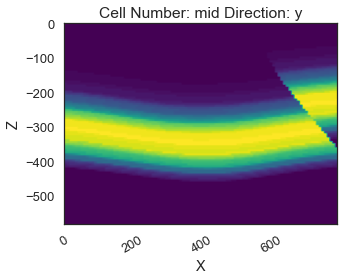

In [99]:
layer = 2
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prob_block[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None}
                  )


To visualize multiple layers, information entropy encapsulate several probability fields in one single metric. This give a general idea of the **uncertain** areas of your domain:

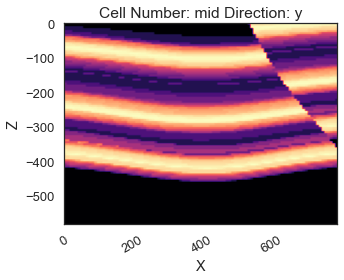

In [100]:
entropy_block = calculate_ie_masked(prob_block)
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=entropy_block,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )



## Intro to Bayesian Inference using pymc3

Until now we have seen how we can propagate uncertainty from the input parameters to hte full 3D model space. Altough in many occassions this may be useful in itself, as the number of stochastic parameters increase it is relatively difficult to keep geological realism in place.

Bayesian inference will allow us not only to have probabilistic models but also to **learn** which of the possible realizations better describe **additional information**.

In this chapter we will see how by combining the forward gravity computation with probabilisitc modeling, we can generate an assamble of models that honor - in this case, the gravity - observation.


<div class="alert alert-block alert-info"><b>Checkpoint:</b> Next cell will load the
model from disk to the necessary state to continue.</div>

In [103]:
!pip install pymc3
# Restart kernel

  Using cached pymc3-3.8-py3-none-any.whl (908 kB)
  Using cached netCDF4-1.5.3-cp37-cp37m-win_amd64.whl (3.1 MB)
  Using cached xarray-0.15.1-py3-none-any.whl (668 kB)
  Using cached cftime-1.1.3-cp37-none-win_amd64.whl (213 kB)


In [1]:
import gempy as gp
import theano

%matplotlib inline
geo_model = gp.load_model_pickle('checkpoint3.pickle')
indices_bool = geo_model.surface_points.df['surface'].isin(['surface1', 'surface2', 'surface3'])
indices = geo_model.surface_points.df.index[indices_bool]
Z_init = geo_model.surface_points.df.loc[indices, 'Z'].copy()
from gempy.bayesian.fields import compute_prob, calculate_ie_masked

For this chapter we are going to need a few extra libraries:

In [2]:
import arviz as az
import pymc3 as pm
import numpy as np


### Replicating the previous example in pymc3

The first step is going to replicate the previous exercise now in `pymc3`. `pymc3` relay on `theano` for automatic differentiation which enable state-of-the-art samplers.

In [3]:
import theano.tensor as tt

def sample_grav(Z_var2):
    Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var2[0],
                       Z_init[[3, 4]] + Z_var2[1],
                       Z_init[[5, 6, 7]] + Z_var2[2]])


    geo_model.modify_surface_points(indices, Z=Z_loc)
    gp.compute_model(geo_model)

    # Returns the 3d lith array
    return geo_model.solutions.fw_gravity

def sample_lith(Z_var):
    Z_loc = np.hstack([Z_init[[1,2,0]] + Z_var[0],
                   Z_init[[3, 4]] + Z_var[1],
                   Z_init[[5, 6, 7]] + Z_var[2]])


    geo_model.modify_surface_points(indices, Z=Z_loc)
    gp.compute_model(geo_model)

    # Returns the 3d lith array
    return geo_model.solutions.lith_block


class GemPyGrav(tt.Op):
    itypes = [tt.fvector]
    otypes = [tt.dvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = sample_grav(theta)
        outputs[0][0] = np.array(mu)

class GemPyLith(tt.Op):
    itypes = [tt.fvector]
    otypes = [tt.dvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = sample_lith(theta)
        outputs[0][0] = np.array(mu)

gempy_grav = GemPyGrav()
gempy_lith = GemPyLith()

In [4]:
with pm.Model() as model:

    Z_var = pm.Normal('Z_var', mu=0, sigma=30, dtype='float32', shape=3)
    grav = pm.Deterministic('gravity', gempy_grav(Z_var))
    lith = pm.Deterministic('lithologies', gempy_lith(Z_var))

In [5]:
with model:
    trace = pm.sample(500, cores=1, chains=1, step = pm.Metropolis(), tune=500)


Sequential sampling (1 chains in 1 job)
Metropolis: [Z_var]
Sampling chain 0, 0 divergences:   2%|▍                               | 15/1000 [00:11<12:18,  1.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [46]:
#data = az.from_pymc3(trace=trace)
#data.to_netcdf('error_propagation')

In [6]:
data = az.from_netcdf('error_propagation')

In [8]:
data.posterior

<xarray.Dataset>
Dimensions:            (Z_var_dim_0: 3, chain: 1, draw: 500, gravity_dim_0: 1, lithologies_dim_0: 100000)
Coordinates:
  * chain              (chain) int32 0
  * draw               (draw) int32 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * Z_var_dim_0        (Z_var_dim_0) int32 0 1 2
  * gravity_dim_0      (gravity_dim_0) int32 0
  * lithologies_dim_0  (lithologies_dim_0) int32 0 1 2 3 ... 99997 99998 99999
Data variables:
    Z_var              (chain, draw, Z_var_dim_0) float32 7.2913566 ... -18.678877
    gravity            (chain, draw, gravity_dim_0) float64 -79.95 ... -79.52
    lithologies        (chain, draw, lithologies_dim_0) float64 ...
Attributes:
    created_at:                 2020-06-08T11:20:58.162737
    arviz_version:              0.8.2
    inference_library:          pymc3
    inference_library_version:  3.8

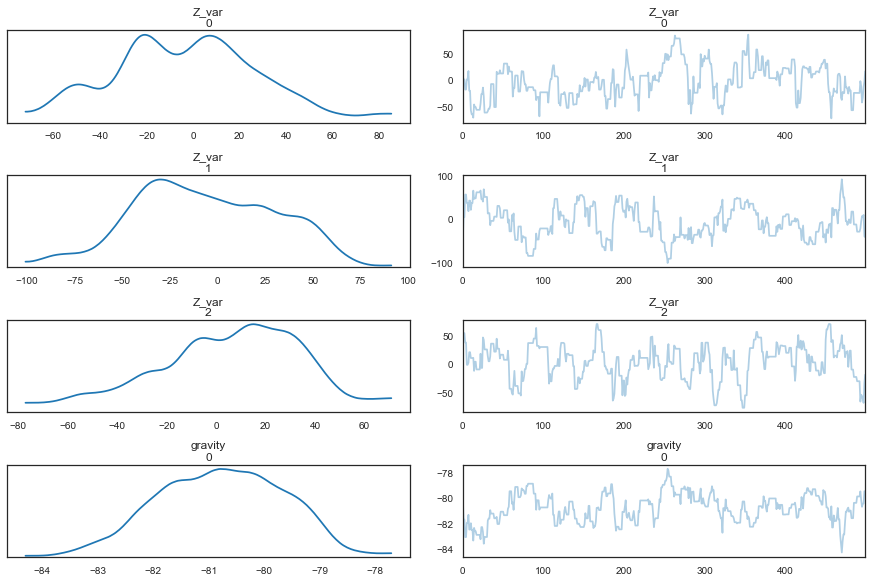

In [10]:
az.plot_trace(data, var_names=['Z_var', 'gravity']);

In [13]:
lith_blocks = data.posterior.lithologies.values[0]

In [14]:
lith_blocks

array([[5., 5., 5., ..., 3., 3., 3.],
       [5., 5., 5., ..., 3., 3., 3.],
       [5., 5., 5., ..., 3., 3., 3.],
       ...,
       [5., 5., 5., ..., 2., 2., 2.],
       [5., 5., 5., ..., 3., 3., 2.],
       [5., 5., 5., ..., 3., 3., 3.]])

In [15]:
prob_block = compute_prob(lith_blocks)


c:\users\legui\pycharmprojects\gempy\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


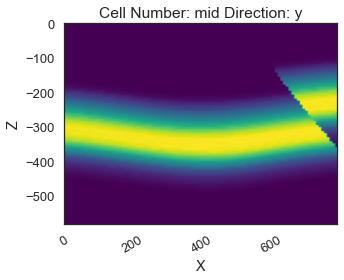

In [16]:
layer = 2
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prob_block[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None}
                  )

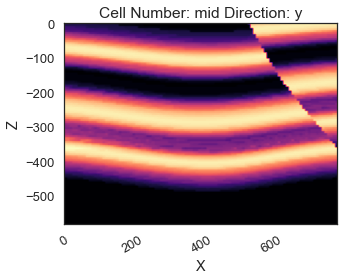

In [17]:
entropy_block = calculate_ie_masked(prob_block)
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=entropy_block,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )


-----------------
### Bayesian Inference


In [18]:
with pm.Model() as model_like:

    Z_var = pm.Normal('Z_var', 0, 30, dtype='float32', shape=3)
    grav = pm.Deterministic('gravity', gempy_grav(Z_var))
    lith = pm.Deterministic('lithologies', gempy_lith(Z_var))

    grav_observed = pm.Normal('y', grav, .5, observed=[-81])

In [58]:
with model_like:
    trace_like = pm.sample(500, cores=1, chains=1, step = pm.Metropolis(), tune=500)




Sequential sampling (1 chains in 1 job)
Metropolis: [Z_var]
Sampling chain 0, 0 divergences: 100%|█████████████████████████████████████████████| 1000/1000 [22:19<00:00,  1.34s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [59]:
# data = az.from_pymc3(trace=trace_like)
# data.to_netcdf('bayes_inference')

In [21]:
data = az.from_netcdf('bayes_inference')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002300158A128>,
      dtype=object)

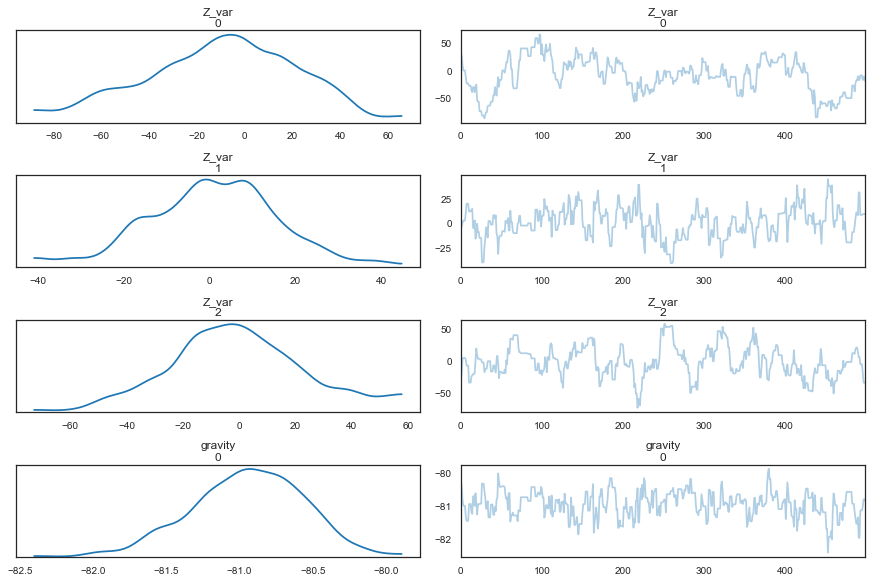

In [61]:
az.plot_trace(data, var_names=['Z_var', 'gravity'])

In [62]:
lith_blocks = data.posterior.lithologies.values[0]

In [63]:
prob_block = compute_prob(lith_blocks)

c:\users\legui\pycharmprojects\gempy\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


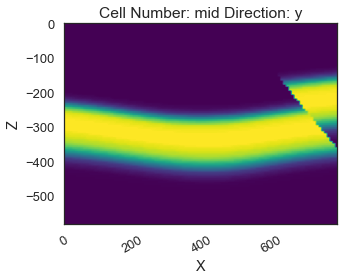

In [64]:
layer = 2
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prob_block[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None}
                  )

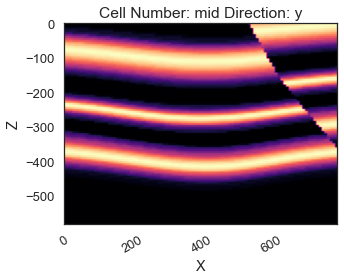

In [65]:
entropy_block = calculate_ie_masked(prob_block)
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=entropy_block,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )


-----

## Thank you for your attention


#### Extra Resources

Page:
https://www.gempy.org/

Paper:
https://www.gempy.org/theory

Gitub:
https://github.com/cgre-aachen/gempy

#### Further training and collaborations
https://www.terranigma-solutions.com/

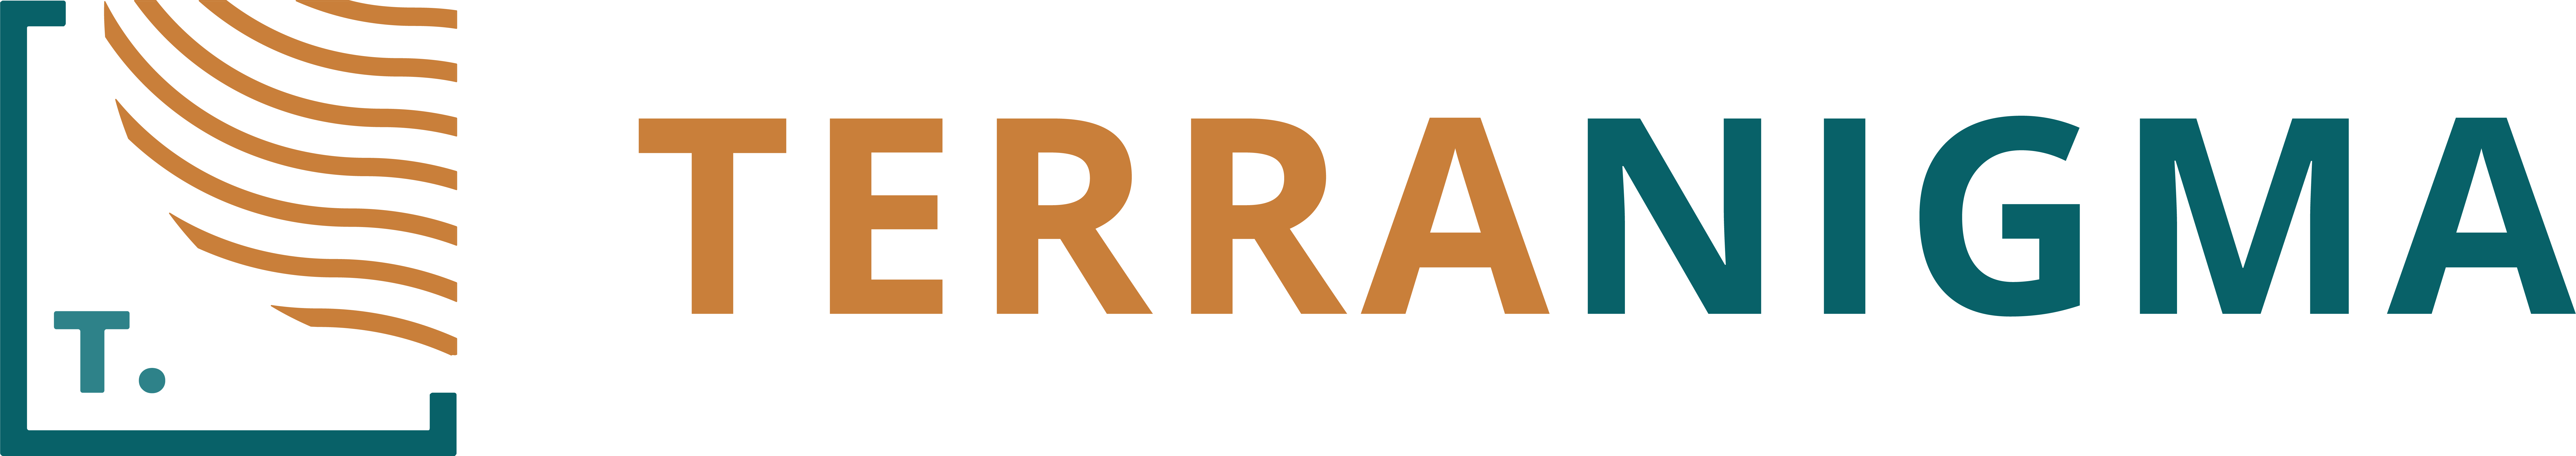

